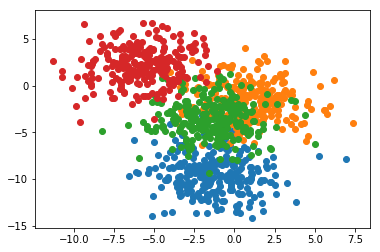

In [3]:
# scatter plot of blobs dataset
from sklearn.datasets import make_blobs
from matplotlib import pyplot
from numpy import where
# generate 2d classification dataset
X, y = make_blobs(n_samples=1000, centers=4, n_features=2, cluster_std=2, random_state=2)
# scatter plot for each class value
for class_value in range(4):
	# select indices of points with the class label
	row_ix = where(y == class_value)
	# scatter plot for points with a different color
	pyplot.scatter(X[row_ix, 0], X[row_ix, 1])
# show plot
#pyplot.show()

In [4]:
# unsupervised greedy layer-wise pretraining for blobs classification problem
from sklearn.datasets import make_blobs
from keras.layers import Dense
from keras.models import Sequential
from keras.optimizers import SGD
from keras.utils import to_categorical
from matplotlib import pyplot

In [5]:
# prepare the dataset
def prepare_data():
	# generate 2d classification dataset
	X, y = make_blobs(n_samples=1000, centers=3, n_features=2, cluster_std=2, random_state=2)
	# one hot encode output variable
	y = to_categorical(y)
	# split into train and test
	n_train = 500
	trainX, testX = X[:n_train, :], X[n_train:, :]
	trainy, testy = y[:n_train], y[n_train:]
	return trainX, testX, trainy, testy

In [6]:
# prepare data
trainX, testX, trainy, testy = prepare_data()

In [7]:
trainy.shape

(500, 3)

In [14]:
# define model
model = Sequential()
#camada densa com 10 neuronios, entrada duas dimensoes
#kernel_initializer=> forma de iniciar os pesos, tambem podemos iniciar as bias
model.add(Dense(10, input_dim=2, activation='relu', kernel_initializer='he_uniform'))
#saida 3 neuronios para cada classe e funcao softmax para a classificacao
model.add(Dense(3, activation='softmax'))

In [12]:
# compile model
#gradiente estacastico descendente com momento 0.9
opt = SGD(lr=0.01, momentum=0.9)#optimizador
model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])
#modelo otimizado com crossentropy

In [19]:
# fit model
model.fit(trainX, trainy, epochs=100, verbose=1)
#defaut = batch de 32

Epoch 1/100
500/500 [==============================] - 0s 52us/step - loss: 0.3844 - accuracy: 0.8360
Epoch 2/100
500/500 [==============================] - 0s 38us/step - loss: 0.3879 - accuracy: 0.8300
Epoch 3/100
500/500 [==============================] - 0s 47us/step - loss: 0.3960 - accuracy: 0.8280
Epoch 4/100
500/500 [==============================] - 0s 53us/step - loss: 0.3926 - accuracy: 0.8240
Epoch 5/100
500/500 [==============================] - 0s 37us/step - loss: 0.3929 - accuracy: 0.8240
Epoch 6/100
500/500 [==============================] - 0s 44us/step - loss: 0.3820 - accuracy: 0.8340
Epoch 7/100
500/500 [==============================] - 0s 39us/step - loss: 0.3832 - accuracy: 0.8300
Epoch 8/100
500/500 [==============================] - 0s 41us/step - loss: 0.3912 - accuracy: 0.8260
Epoch 9/100
500/500 [==============================] - 0s 43us/step - loss: 0.3916 - accuracy: 0.8280
Epoch 10/100
500/500 [==============================] - 0s 31us/step - loss: 0.386

In [15]:
# define and fit the base model
def get_base_model(trainX, trainy):
	# define model
	model = Sequential()
	model.add(Dense(10, input_dim=2, activation='relu', kernel_initializer='he_uniform'))
	model.add(Dense(3, activation='softmax'))
	# compile model
	opt = SGD(lr=0.01, momentum=0.9)
	model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])
	# fit model
	model.fit(trainX, trainy, epochs=100, verbose=0)
	return model

In [22]:
# get the base model
model = get_base_model(trainX, trainy)


In [36]:
# evaluate a fit model
#verbose mostra o progesso do treino 0 nao mostra nada, 1 e 2 mostra a barra
def evaluate_model(model, trainX, testX, trainy, testy):
	_,train_acc = model.evaluate(trainX, trainy, verbose=0)
	_,test_acc = model.evaluate(testX, testy, verbose=0)
	return train_acc, test_acc

In [37]:
evaluate_model(model,trainX,testX,trainy,testy)

(0.8339999914169312, 0.8299999833106995)

In [38]:
# evaluate the base model
scores = dict()
train_acc, test_acc = evaluate_model(model, trainX, testX, trainy, testy)
print('> layers=%d, train=%.3f, test=%.3f' % (len(model.layers), train_acc, test_acc))

> layers=2, train=0.834, test=0.830


""" É necessária uma função que pode adicionar uma nova camada oculta e retreinar o modelo, mas apenas atualizar os pesos na camada recém-adicionada e na camada de saída.

Isso requer primeiro o armazenamento da camada de saída atual, incluindo sua configuração e o conjunto atual de pesos."""

In [44]:
# remember the current output layer
output_layer = model.layers[-1]
#armazenando a camada de saida

Em seguida, removendo a camada de saída da pilha de camadas no modelo.

In [45]:
# remove the output layer
model.pop()


estou tirando a camada de saida, pois eu quero que ela seja treinada junto com a camda adicionada, faco isso, pois a proxima funcao vai deixar todas as camadas nao treinaveis

Todas as camadas restantes no modelo podem ser marcadas como não treináveis, o que significa que seus pesos não podem ser atualizados quando a função fit () for chamada novamente.

In [47]:
# mark all remaining layers as non-trainable
for layer in model.layers:
	layer.trainable = False

Podemos então adicionar uma nova camada oculta, neste caso com a mesma configuração da primeira camada oculta adicionada no modelo base.

In [49]:
# add a new hidden layer
model.add(Dense(10, activation='relu', kernel_initializer='he_uniform'))

Finalmente, a camada de saída pode ser adicionada de volta e o modelo pode ser reajustado no conjunto de dados de treinamento

In [50]:
# re-add the output layer
model.add(output_layer)
# fit model
model.fit(trainX, trainy, epochs=100, verbose=0)

Podemos amarrar todos esses elementos em uma função chamada add_layer () que leva o modelo e o conjunto de dados de treinamento como argumentos.

como a camada verdadeira nao esta treinavel, eu adiciona uma nova camada para pre treinar a rede, ela eh igual.

In [51]:
# add one new layer and re-train only the new layer
def add_layer(model, trainX, trainy):
	# remember the current output layer
	output_layer = model.layers[-1]#armazeno a ultima camada em output_layer
	# remove the output layer(removo ela da rede)
	model.pop()
	# mark all remaining layers as non-trainable(mantenho todas as camadas com os pesos
    #sem atualizacao)
	for layer in model.layers:
		layer.trainable = False
	# add a new hidden layer(essa camada vai ser treinada com a saida, as outras
    #sao mantidas com os pesos sem atualizar)
	model.add(Dense(10, activation='relu', kernel_initializer='he_uniform'))
	# re-add the output layer
	model.add(output_layer)#(adiciona a nova camada)
	# fit model
	model.fit(trainX, trainy, epochs=100, verbose=0)

Esta função pode então ser chamada repetidamente com base no número de camadas que desejamos adicionar ao modelo.

Nesse caso, adicionaremos 10 camadas, uma de cada vez, e avaliaremos o desempenho do modelo após cada camada adicional ser adicionada para ter uma ideia de como ela está afetando o desempenho.

As pontuações de precisão de treinamento e teste são armazenadas no dicionário em relação ao número de camadas do modelo.

In [52]:
# add layers and evaluate the updated model
n_layers = 20
for i in range(n_layers):
	# add layer
	add_layer(model, trainX, trainy)
	# evaluate model
	train_acc, test_acc = evaluate_model(model, trainX, testX, trainy, testy)
	print('> layers=%d, train=%.3f, test=%.3f' % (len(model.layers), train_acc, test_acc))
	# store scores for plotting
	scores[len(model.layers)] = (train_acc, test_acc)


> layers=4, train=0.848, test=0.818
> layers=5, train=0.854, test=0.828
> layers=6, train=0.858, test=0.822
> layers=7, train=0.848, test=0.822
> layers=8, train=0.852, test=0.826
> layers=9, train=0.848, test=0.824
> layers=10, train=0.846, test=0.824
> layers=11, train=0.852, test=0.824
> layers=12, train=0.848, test=0.826
> layers=13, train=0.854, test=0.824


No final da execução, um gráfico de linha é criado mostrando o número de camadas no modelo (eixo x) em comparação com a precisão do modelo numérico no trem e nos conjuntos de dados de teste.

Esperaríamos a adição de camadas para melhorar o desempenho do modelo no conjunto de dados de treinamento e talvez até mesmo no conjunto de dados de teste.

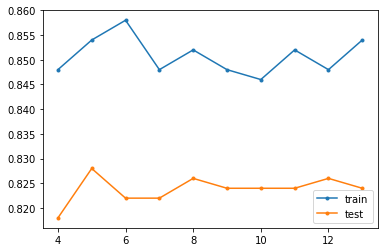

In [53]:
# plot number of added layers vs accuracy
pyplot.plot(list(scores.keys()), [scores[k][0] for k in scores.keys()], label='train', marker='.')
pyplot.plot(list(scores.keys()), [scores[k][1] for k in scores.keys()], label='test', marker='.')
pyplot.legend()
pyplot.show()

> layers=2, train=0.828, test=0.818
> layers=3, train=0.848, test=0.822
> layers=4, train=0.832, test=0.818
> layers=5, train=0.832, test=0.818
> layers=6, train=0.838, test=0.818
> layers=7, train=0.838, test=0.818
> layers=8, train=0.842, test=0.818
> layers=9, train=0.840, test=0.818
> layers=10, train=0.838, test=0.816
> layers=11, train=0.840, test=0.820
> layers=12, train=0.834, test=0.820
> layers=13, train=0.838, test=0.820
> layers=14, train=0.838, test=0.816
> layers=15, train=0.840, test=0.816
> layers=16, train=0.836, test=0.816
> layers=17, train=0.830, test=0.820
> layers=18, train=0.838, test=0.814
> layers=19, train=0.828, test=0.814
> layers=20, train=0.840, test=0.814
> layers=21, train=0.832, test=0.814
> layers=22, train=0.836, test=0.816


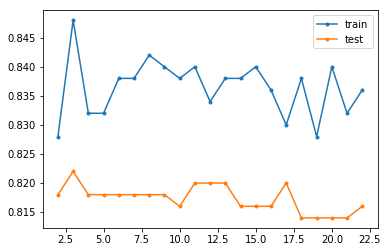

In [55]:
# supervised greedy layer-wise pretraining for blobs classification problem
from sklearn.datasets import make_blobs
from keras.layers import Dense
from keras.models import Sequential
from keras.optimizers import SGD
from keras.utils import to_categorical
from matplotlib import pyplot

# prepare the dataset
def prepare_data():
	# generate 2d classification dataset
	X, y = make_blobs(n_samples=1000, centers=3, n_features=2, cluster_std=2, random_state=2)
	# one hot encode output variable
	y = to_categorical(y)
	# split into train and test
	n_train = 500
	trainX, testX = X[:n_train, :], X[n_train:, :]
	trainy, testy = y[:n_train], y[n_train:]
	return trainX, testX, trainy, testy

# define and fit the base model
def get_base_model(trainX, trainy):
	# define model
	model = Sequential()
	model.add(Dense(10, input_dim=2, activation='relu', kernel_initializer='he_uniform'))
	model.add(Dense(3, activation='softmax'))
	# compile model
	opt = SGD(lr=0.01, momentum=0.9)
	model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])
	# fit model
	model.fit(trainX, trainy, epochs=100, verbose=0)
	return model

# evaluate a fit model
def evaluate_model(model, trainX, testX, trainy, testy):
	_, train_acc = model.evaluate(trainX, trainy, verbose=0)
	_, test_acc = model.evaluate(testX, testy, verbose=0)
	return train_acc, test_acc

# add one new layer and re-train only the new layer
def add_layer(model, trainX, trainy):
	# remember the current output layer
	output_layer = model.layers[-1]
	# remove the output layer
	model.pop()
	# mark all remaining layers as non-trainable
	for layer in model.layers:
		layer.trainable = False
	# add a new hidden layer
	model.add(Dense(10, activation='relu', kernel_initializer='he_uniform'))
	# re-add the output layer
	model.add(output_layer)
	# fit model
	model.fit(trainX, trainy, epochs=100, verbose=0)

# prepare data
trainX, testX, trainy, testy = prepare_data()
# get the base model
model = get_base_model(trainX, trainy)
# evaluate the base model
scores = dict()
train_acc, test_acc = evaluate_model(model, trainX, testX, trainy, testy)
print('> layers=%d, train=%.3f, test=%.3f' % (len(model.layers), train_acc, test_acc))
scores[len(model.layers)] = (train_acc, test_acc)
# add layers and evaluate the updated model
n_layers = 20
for i in range(n_layers):
	# add layer
	add_layer(model, trainX, trainy)
	# evaluate model
	train_acc, test_acc = evaluate_model(model, trainX, testX, trainy, testy)
	print('> layers=%d, train=%.3f, test=%.3f' % (len(model.layers), train_acc, test_acc))
	# store scores for plotting
	scores[len(model.layers)] = (train_acc, test_acc)
# plot number of added layers vs accuracy
pyplot.plot(list(scores.keys()), [scores[k][0] for k in scores.keys()], label='train', marker='.')
pyplot.plot(list(scores.keys()), [scores[k][1] for k in scores.keys()], label='test', marker='.')
pyplot.legend()
pyplot.show()

Nesse caso, podemos ver que o modelo de linha de base se sai razoavelmente bem com esse problema. Conforme as camadas são aumentadas, podemos ver aproximadamente um aumento na precisão do modelo no conjunto de dados de treinamento, provavelmente porque ele está começando a super ajustar os dados. Vemos uma queda brusca na precisão da classificação no conjunto de dados de teste, provavelmente devido ao sobreajuste.

0.828000009059906

In [59]:
scores

{2: (0.828000009059906, 0.8180000185966492),
 3: (0.8479999899864197, 0.8220000267028809),
 4: (0.8320000171661377, 0.8180000185966492),
 5: (0.8320000171661377, 0.8180000185966492),
 6: (0.8379999995231628, 0.8180000185966492),
 7: (0.8379999995231628, 0.8180000185966492),
 8: (0.8420000076293945, 0.8180000185966492),
 9: (0.8399999737739563, 0.8180000185966492),
 10: (0.8379999995231628, 0.8159999847412109),
 11: (0.8399999737739563, 0.8199999928474426),
 12: (0.8339999914169312, 0.8199999928474426),
 13: (0.8379999995231628, 0.8199999928474426),
 14: (0.8379999995231628, 0.8159999847412109),
 15: (0.8399999737739563, 0.8159999847412109),
 16: (0.8360000252723694, 0.8159999847412109),
 17: (0.8299999833106995, 0.8199999928474426),
 18: (0.8379999995231628, 0.8140000104904175),
 19: (0.828000009059906, 0.8140000104904175),
 20: (0.8399999737739563, 0.8140000104904175),
 21: (0.8320000171661377, 0.8140000104904175),
 22: (0.8360000252723694, 0.8159999847412109)}